# U-net Arcitectures and example Workflow

- model building
- model training
- implementing U-net architecture for unsupervised change detection

- Attention U-net: https://arxiv.org/pdf/1804.03999.pdf 

- ** Find paper for residual U-net
    - implement SWIN-T block 
    - figure our reccurent residual block
    - figure out other attention variants of u-net that perform better than ones implemented here

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, concatenate, multiply, Lambda, LeakyReLU, Add
from tensorflow.keras import backend as kb
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
from segmentation_models.losses import categorical_focal_jaccard_loss
from segmentation_models.metrics import iou_score
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

## U-net

In [2]:
def conv_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Convolutional Block
    
    Arguments:
        inputs - input tensor usually image shape (x, x, 3)
        n_filters - number of filters for conv layers
        dropout_prob - dropout probability (added for model regularization)
        
    Performs 2 convolutional steps with kernel size (3,3) stride 1 followed by batch normalization and or dropout depending
    on parameter sepcifications
    
    Returns:
        conv_layer 
        
    """
    act_fn = LeakyReLU(alpha=0.2)
    
    # first conv layer
    conv1 = Conv2D(n_filters, 3, padding='same')(inputs)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 2nd conv layer
    conv2 = Conv2D(n_filters, 3, padding='same')(conv1)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    
    # adding Dropout 
    if dropout_prob > 0:
        conv2 = Dropout(dropout_prob)(conv2)
    
    return conv2
   

In [3]:
def encoder_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Encoder Block (downsampling)
    
    Applies max pooling (2,2) to downsample the input conv_block and return skip connection and next layer input
    
    Arguments:
    Inherits the parameters from the input conv_block
    
        inputs - output of conv_block 
        n_filters - number of filters to applied to conv_block
        dropout_prob - probability of dropout
    
    Returns:
        next_layer, skip connection
    """
    
    skip_connection = conv_block(inputs, n_filters, batch_norm, dropout_prob)
    next_layer = MaxPooling2D((2,2))(skip_connection)
    
    return next_layer, skip_connection

In [4]:
def decoder_block(expansive_input, contractive_input, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Convolutional Upsampling Block
    
    Apply Conv2DTranspose stride 2 or Upsampling2D to upsample lower level feature embeddings spatially to the same dimensions
    as the skip_connections for concatenation, concatenate them, pass them through normally convolutional block,
    then return the output to be used as the input for the next upsampling block in the model
    
    Arguments:
        expansive_input - Input tensor from previous layer
        contractive_input - Input tensor from previous skip layer (skip_connection)
        
    Returns:
        conv - Tensor
    """
    
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    
    # merge upsampled input with skip connection
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = conv_block(merge, n_filters, batch_norm, dropout_prob)
    
    return conv 

In [7]:
def unet_model(input_size=(512, 512, 3), n_filters=64, n_classes=5, batch_norm=True):
    
    """
    U-net Model
    
    Arguments:
        input_size: size of input image (often in preprocess we tile the original sattelite image to a smaller scale)
        n_filters: number of filters (feature maps or kernels) for conv layers 
        n_classes: number of target classes
        
    Return:
        model - tf.keras.model
    """
    FILTER_SIZE = 3
    inputs = Input(input_size)
    
    # encoder
    # Double the number of filters at each time step
    
    # inputs inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm
    
    enc_block1 = encoder_block(inputs, n_filters, 0, batch_norm)
    
    enc_block2 = encoder_block(enc_block1[0], n_filters*2, batch_norm)
    
    enc_block3 = encoder_block(enc_block2[0],  n_filters*4, batch_norm)
    
    enc_block4 = encoder_block(enc_block3[0],  n_filters*8, batch_norm, 0.3)
    
    # conv block instead of encoder block (Bridge)
    bridge = conv_block(enc_block4[0],  n_filters*16, batch_norm, 0.3)
    
    
    # decoder      
            
    # chain the output of the previous block as expansive_input and the corresponding contractive block output
    # use half number of filters at each time step
    
    dec_block4 = decoder_block(bridge, enc_block4[1],  n_filters*8, batch_norm)
    
    dec_block3 = decoder_block(dec_block4, enc_block3[1],  n_filters*4, batch_norm)
    
    dec_block2 = decoder_block(dec_block3, enc_block2[1], n_filters*2, batch_norm)
    
    dec_block1 = decoder_block(dec_block2, enc_block1[1],  n_filters, batch_norm)
    
    # output tensor with number of channels based on number of target classes
    conv10 = Conv2D(n_classes, 1, padding='same', activation='softmax')(dec_block1)


    # create model object
    model = tf.keras.Model(inputs=inputs, outputs=conv10, name='U-net')
    
    return model
    
    

In [8]:
unet = unet_model((512,512,3))
unet.summary()

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       leaky_re_lu_1[0][0]              
______________________________________________________________________________________________

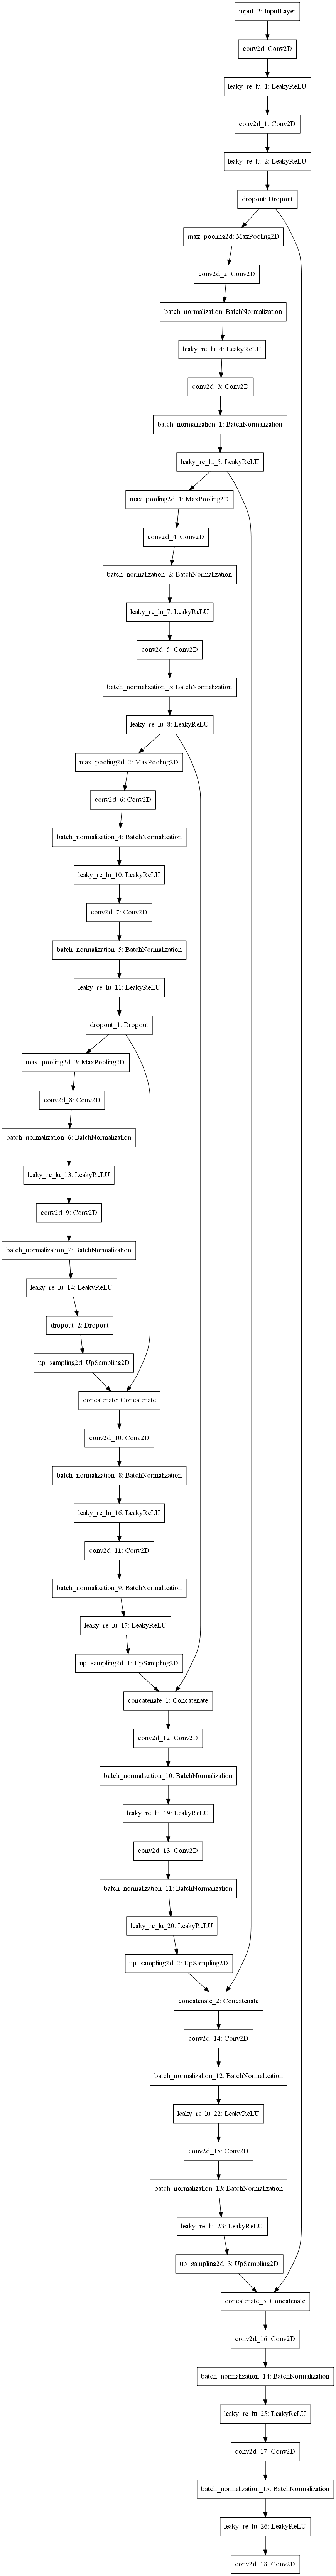

In [9]:
#visualize the model
tf.keras.utils.plot_model(
   unet, to_file='model.png', show_shapes=False, show_dtype=False,
   show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

## Attention U-net

In [8]:
def expand_as(tensor, rep):
    
    """
    Arguments:
        tensor, rep
    Repeats elemts of a tensor along specified axis by a factor of rep
    essentially expands the number of filters or bands in the tensor by repeating the input
    used in the attention mechanism to make sure tensors are of the same size before concatenation
    
    (None, 256, 256, 3) rep = 2 => (None, 256, 256, 6)
    
    Return:
        expanded tensor
    """
    
    return Lambda(lambda x, repnum: kb.repeat_elements(x, repnum, axis=3),
                 arguments={'repnum': rep})(tensor)

In [9]:
def gating_signal(inputs, out_size, batch_norm=False):
    
    """
    Arguments: 
        inputs - tensor
        out_size - output dimension
        batch_norm - Boolen determining if BatchNormalization will be applied or not
        
        resize the down layer feature map into the same dimension as the up layer feature map using 1x1 convolution
        
        Return:
            gating feature map with the same dimension as the up layer feature map
    """
    
    gate = Conv2D(out_size, 1, padding='same')(inputs)
    
    if batch_norm:
        gate = BatchNormalization(axis=3)(gate)
        
    gate = LeakyReLU(alpha=0.2)(gate)
    
    return gate

In [10]:
def attention_block(skip_connection, gate, inter_shape):
    
    """
    Arguments:
        skip_connection - input tensor from corresponding skip connection in the heirarchy
        gate - gating signal from corresponding level
        inter_shape - expected tensor shape
        
    Takes skip_connections from earlier layers for added spatial information and adds them to the gate activations
    which come from deeper layers with denser feature information and passes them through several activations
    resulting in a layer of attention weights which are learned to give more weight to the spatial areas of most importance
    within the input image when making classifications
    
    Returns:
        contractive input to be added to the expansive input (up) in the decoder block
    """
    
    shape_skip = kb.int_shape(skip_connection)
    shape_gate = kb.int_shape(gate)
    
    phi_g = Conv2D(inter_shape, 1, padding='same')(gate)
    
    theta_skip = Conv2D(inter_shape, 2, strides=(2,2), padding='same')(skip_connection)
    shape_theta_skip = kb.int_shape(theta_skip)
    
    upsample_g = Conv2DTranspose(inter_shape, 3,
                                strides=(shape_theta_skip[1] // shape_gate[1], shape_theta_skip[2] // shape_gate[2]),
                                padding='same')(phi_g)
    
    concat_sg = concatenate([upsample_g, theta_skip], axis=3)
    
    act_sg = LeakyReLU(alpha=0.2)(concat_sg)
    
    psi = Conv2D(1, (1,1), padding='same')(act_sg)
    
    sigmoid_sg = LeakyReLU(alpha=0.2)(psi)
    
    shape_sigmoid = kb.int_shape(sigmoid_sg)
    
    upsample_psi = UpSampling2D(size=(shape_skip[1] // shape_sigmoid[1], shape_skip[2] // shape_sigmoid[2]))(sigmoid_sg)
    
    upsample_psi = expand_as(upsample_psi, shape_skip[3])
    
    y = multiply([upsample_psi, skip_connection])
    
    result = Conv2D(shape_skip[3], (1,1), padding='same')(y)
    
    result_bn = BatchNormalization(axis=3)(result)
    
    return result_bn

In [11]:
def attention_unet_model(input_size=(256, 256, 3), n_filters=64, n_classes=5, batch_norm=True):
    
    
    """
    Attention U-net Model

    Arguments:
        input_size: size of input image (often in preprocess we tile the original sattelite image to a smaller scale)
        n_filters: number of filters (feature maps or kernels) for conv layers 
        n_classes: number of target classes

    Return:
        model - tf.keras.model
    """
    inputs = Input(input_size)

    # encoder
    # Double the number of filters at each time step

    enc_block1 = encoder_block(inputs, n_filters, batch_norm)

    enc_block2 = encoder_block(enc_block1[0], n_filters*2, batch_norm)

    enc_block3 = encoder_block(enc_block2[0], n_filters*4, batch_norm)

    enc_block4 = encoder_block(enc_block3[0], n_filters*8, batch_norm, dropout_prob=0.3)

    # conv block instead of encoder block (Bridge)
    bridge = conv_block(enc_block4[0], n_filters*16, batch_norm, dropout_prob=0.3)

    # decoder

    # chain the output of the previous block as expansive_input and the corresponding contractive block output
    # use half number of filters at each time step
    gating_4 = gating_signal(bridge, n_filters*8, batch_norm)
    att_4 = attention_block(enc_block4[1], gating_4, n_filters*8)
    dec_block4 = decoder_block(att_4, enc_block4[1], n_filters*8, batch_norm)

    gating_3 = gating_signal(dec_block4, n_filters*4, batch_norm)
    att_3 = attention_block(enc_block3[1], gating_3, n_filters*4)
    dec_block3 = decoder_block(att_3, enc_block3[1], n_filters*4, batch_norm)

    gating_2 = gating_signal(dec_block3, n_filters*2, batch_norm)
    att_2 = attention_block(enc_block2[1], gating_2, n_filters*2)
    dec_block2 = decoder_block(att_2, enc_block2[1], n_filters*2, batch_norm)

    gating_1 = gating_signal(dec_block2, n_filters, batch_norm)
    att_1 = attention_block(enc_block1[1], gating_1, n_filters)
    dec_block1 = decoder_block(att_1, enc_block1[1], n_filters, batch_norm)

    # output tensor with number of channels based on number of target classes
    conv10 = Conv2D(n_classes, 1, padding='same', activation='softmax')(dec_block1)

    # create model object
    model = tf.keras.Model(inputs=inputs, outputs=conv10, name='AttU-net')

    return model

In [12]:
#img_shape = (256,256,3)
#att_unet = attention_unet_model(img_shape)
#att_unet.summary()

## Residual Attention U-net

In [13]:
def res_conv_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Residual Convolutional Block
    
    Arguments:
        inputs - input tensor usually image shape (x, x, 3)
        n_filters - number of filters for conv layers
        dropout_prob - dropout probability (added for model regularization)
        
    Performs 2 convolutional steps with kernel size (3,3) stride 1 followed by batch normalization and or dropout depending
    on parameter sepcifications and adds a residual connection
    
    Returns:
        conv_layer 
        
    """
    act_fn = LeakyReLU(alpha=0.2)
    
    # first conv layer
    conv1 = Conv2D(n_filters, 3, padding='same')(inputs)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 2nd conv layer
    conv2 = Conv2D(n_filters, 3, padding='same')(conv1)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    
    # adding Dropout 
    if dropout_prob > 0:
        conv2 = Dropout(dropout_prob)(conv2)
    
    # residual connection
    res_connection = Conv2D(n_filters, 1, padding='same')(inputs)
    if batch_norm:
        res_connection = BatchNormalization(axis=3)(res_connection)
    
    res_conv = concatenate([res_connection, conv2])
    res_conv = LeakyReLU(alpha=0.2)(res_conv)
    
    return res_conv

In [14]:
def res_encoder_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Residual Encoder Block (downsampling)
    
    Applies max pooling (2,2) to downsample the input conv_block and return skip connection and next layer input adds
    residual connection
    
    Arguments:
    Inherits the parameters from the input conv_block
    
        inputs - output of conv_block 
        n_filters - number of filters to applied to conv_block
        dropout_prob - probability of dropout
    
    Returns:
        next_layer, skip connection
    """
    
    skip_connection = res_conv_block(inputs, n_filters, batch_norm, dropout_prob)
    next_layer = MaxPooling2D((2,2))(skip_connection)
    
    return next_layer, skip_connection

In [15]:
def res_decoder_block(expansive_input, contractive_input, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Residual Convolutional Upsampling Block
    
    Apply Conv2DTranspose stride 2 or Upsampling2D to upsample lower level feature embeddings spatially to the same dimensions
    as the skip_connections for concatenation, concatenate them, pass them through normally convolutional block,
    then return the output to be used as the input for the next upsampling block in the model
    
    Arguments:
        expansive_input - Input tensor from previous layer
        contractive_input - Input tensor from previous skip layer (skip_connection)
        
    Returns:
        conv - Tensor
    """
    
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    
    # merge upsampled input with skip connection
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = res_conv_block(merge, n_filters, batch_norm, dropout_prob)
    
    return conv

In [16]:
def res_attention_unet_model(input_size=(256, 256, 3), n_filters=64, n_classes=5, batch_norm=True):
    
    
    """
    Residual Attention U-net Model

    Arguments:
        input_size: size of input image (often in preprocess we tile the original sattelite image to a smaller scale)
        n_filters: number of filters (feature maps or kernels) for conv layers 
        n_classes: number of target classes

    Return:
        model - tf.keras.model
    """
    inputs = Input(input_size)

    # encoder
    # Double the number of filters at each time step

    enc_block1 = res_encoder_block(inputs, n_filters, batch_norm)

    enc_block2 = res_encoder_block(enc_block1[0], n_filters*2, batch_norm)

    enc_block3 = res_encoder_block(enc_block2[0], n_filters*4, batch_norm)

    enc_block4 = res_encoder_block(enc_block3[0], n_filters*8, batch_norm, dropout_prob=0.3)

    # conv block instead of encoder block (Bridge)
    bridge = res_conv_block(enc_block4[0], n_filters*16, batch_norm, dropout_prob=0.3)

    # decoder

    # chain the output of the previous block as expansive_input and the corresponding contractive block output
    # use half number of filters at each time step
    gating_4 = gating_signal(bridge, n_filters*8, batch_norm)
    att_4 = attention_block(enc_block4[1], gating_4, n_filters*8)
    dec_block4 = res_decoder_block(att_4, enc_block4[1], n_filters*8, batch_norm)

    gating_3 = gating_signal(dec_block4, n_filters*4, batch_norm)
    att_3 = attention_block(enc_block3[1], gating_3, n_filters*4)
    dec_block3 = res_decoder_block(att_3, enc_block3[1], n_filters*4, batch_norm)

    gating_2 = gating_signal(dec_block3, n_filters*2, batch_norm)
    att_2 = attention_block(enc_block2[1], gating_2, n_filters*2)
    dec_block2 = res_decoder_block(att_2, enc_block2[1], n_filters*2, batch_norm)

    gating_1 = gating_signal(dec_block2, n_filters, batch_norm)
    att_1 = attention_block(enc_block1[1], gating_1, n_filters)
    dec_block1 = res_decoder_block(att_1, enc_block1[1], n_filters, batch_norm)

    # output tensor with number of channels based on number of target classes
    conv10 = Conv2D(n_classes, 1, padding='same', activation='softmax')(dec_block1)
    
    # create model object
    model = tf.keras.Model(inputs=inputs, outputs=conv10, name='ResAttU-net')

    return model

In [19]:
img_shape=(256,256,3)
res_att_unet = res_attention_unet_model(img_shape)
#res_att_unet.summary()

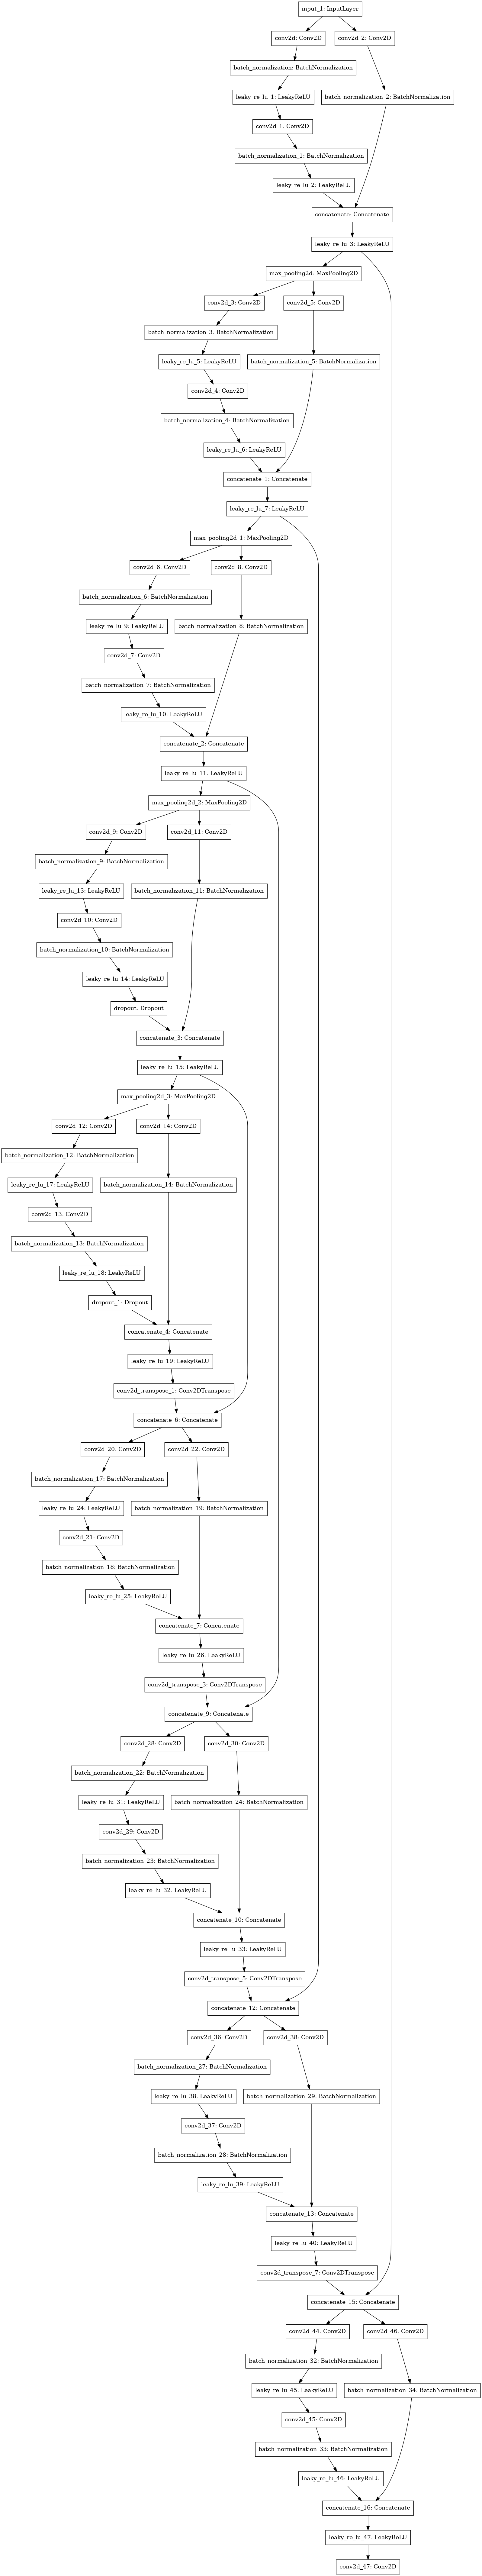

In [18]:
#visualize the model
tf.keras.utils.plot_model(
   res_att_unet, to_file='model.png', show_shapes=False, show_dtype=False,
   show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)